In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

torch.__version__

'2.5.1'

In [2]:
# внутри батчей двигаться скользящим окном

In [3]:
import numpy as np
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torch.utils.data import Dataset, DataLoader
# Константы
num_trajectories = 368  # Количество траекторий
num_radars = 16  # Количество радаров
data_path = 'last_data'  # Путь к данным
# input_features = ['x_measure', 'y_measure', 'z_measure',
#                   'v_x_measure', 'v_y_measure', 'v_z_measure',
#                                                 
#                   'r_measure', 'theta_measure', 'fi_measure',
#                   'v_r_measure', 'v_theta_measure', 'v_fi_measure',
#                   
#                   'r_mean', 'theta_mean', 'fi_mean',
#                   'r_error', 'theta_error', 'fi_error',
#                   ]  # Входные признаки

input_features = ['x_measure', 'y_measure', 'z_measure',
                  'v_x_measure', 'v_y_measure', 'v_z_measure',

                  'r_measure', 'theta_measure', 'fi_measure',
                  'v_r_measure', 'v_theta_measure', 'v_fi_measure',

                  'theta_mean',
                  'r_error', 'theta_error', 'fi_error',
                  ]  # Входные признаки

# input_features = ['x_measure', 'y_measure', 'z_measure', 'v_x_measure_extr', 'v_y_measure_extr', 'v_z_measure_extr', 'r_measure', 'fi_measure', 'psi_measure']

target_feature = 'x_true'  # Целевая координата

def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси для одного радара
    return trajectory_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    trajectory_data = load_trajectory_data(traj_idx)
    
    # Для каждого радара, собираем последовательность (seq_length, num_features)
    radar_data = []
    radar_targets = []  # Список для целевых значений для каждого радара
    for radar_idx in range(num_radars):
        data = trajectory_data[radar_idx]
        X = data[input_features].values  # Входные данные для радарa
        y = data[target_feature].values  # Истинная координата
        
        radar_data.append(X)
        radar_targets.append(y)
    
    # Преобразуем данные в форму (num_radars, seq_length, num_features)
    X_data.append(np.array(radar_data))  # (num_radars, seq_length, num_features)
    y_data.append(np.array(radar_targets)) # (num_radars, seq_length)

# Преобразуем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, num_radars, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, num_radars, seq_length)

# Заменяем NaN на 0 и Inf на большое число
X_data = np.nan_to_num(X_data, nan=0.0, posinf=1e6, neginf=-1e6)
y_data = np.nan_to_num(y_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Теперь транспонируем X_data, y_data чтобы размерность стала (num_trajectories * num_radars, seq_length, num_features)
# X_data = X_data.reshape(-1, X_data.shape[2], X_data.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
# y_data = y_data.reshape(-1, y_data.shape[2])  # (num_trajectories * num_radars, seq_length)

# Проверим размерность данных
print(X_data.shape)  # (368*16, seq_length, num_features) 
print(y_data.shape)  # (368*16, seq_length)


device:  cuda
(368, 16, 1001, 16)
(368, 16, 1001)


In [112]:
# НЕ УВЕРЕН ЧТО В ОДИН БАТЧ ПОПАДАЕТ ТОЛЬКО ОДНА РАЗНОВИДНОСТЬ ТРАЕТОРИИ
# И ПОДУМАТЬ НАДО ЛИ ПЕРЕМЕШИВАТЬ И ВСЯКОЕ ТАКОЕ

In [17]:
class RadarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_size = int(0.8 * num_trajectories * num_radars)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Создаем DataLoader
batch_size = 16  # Один батч — 16 различных реализаций от радаров для одной траектории
train_dataset = RadarDataset(X_train, y_train)
test_dataset = RadarDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)  # Не перемешиваем данные
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) 

# Пример батча
for X_batch, y_batch in train_loader:
    print(X_batch.shape)  # (16, seq_length, num_features) для каждого батча
    print(y_batch.shape)  # (16, seq_length)
    print(X_batch[0][0])
    break


torch.Size([16, 16, 1001, 16])
torch.Size([16, 16, 1001])
tensor([[ 4.6878e+04,  4.7480e+04, -1.9217e+03,  ...,  1.5183e+00,
          2.1854e-03,  1.4503e-03],
        [ 4.6916e+04,  4.7170e+04, -1.7702e+03,  ...,  1.5183e+00,
          2.1854e-03,  1.4503e-03],
        [ 4.6856e+04,  4.6947e+04, -2.0200e+03,  ...,  1.5183e+00,
          2.1854e-03,  1.4503e-03],
        ...,
        [ 4.8849e+04,  2.4335e+04, -1.3216e+03,  ...,  1.5183e+00,
          2.1854e-03,  1.4503e-03],
        [ 4.8816e+04,  2.4317e+04, -1.3074e+03,  ...,  1.5183e+00,
          2.1854e-03,  1.4503e-03],
        [ 4.8702e+04,  2.4457e+04, -1.4373e+03,  ...,  1.5183e+00,
          2.1854e-03,  1.4503e-03]])


------------------------------------------------------------------------------ MODEL ------------------------------------------------------------------------------

In [117]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)  # Выходной слой для регрессии
        
    def forward(self, x):
        print("in forward, x ", x.shape)
        out, _ = self.lstm(x)  # Получаем выход LSTM
        print("in forward, out ", out.shape)
        last_out = out[:, -1, :]  # Берем выход ТОЛЬКО для последнего шага
        print("in forward, last_out ", last_out.shape)
        return self.fc(last_out)  # Пропускаем через линейный слой

    # def forward(self, x):
    #     #LSTM: возвращает все временные шаги и последний скрытый слой
    #     out, (hidden, _) = self.lstm(x)
    #     # Выбираем последнее состояние и пропускаем через линейный слой
    #     return self.fc(hidden[-1])

In [120]:
def train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, print_flag=True):
    history = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            print(X_batch.shape, y_batch.shape)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    
            # Обнуление градиентов
            optimizer.zero_grad()
    
            # Прямой проход
            outputs = model(X_batch)
            outputs = outputs.squeeze(-1)  # Убираем последнюю размерность для совместимости
            print("in train, outputs ", outputs.shape)
    
            # Проверяем размерность целевого тензора
            if len(y_batch.shape) > 1:
                y_batch = y_batch[:, -1]  # Берем последний временной шаг для истинного значения
    
            # Вычисляем потери
            print("in train, y_batch ", y_batch.shape)
            loss = criterion(outputs, y_batch)
            # print("loss", loss)
    
            # Обратный проход
            loss.backward()
            
            for name, param in model.named_parameters():
                if torch.all(torch.isnan(param.grad)):
                    print(name, "NAN")

            optimizer.step()
            scheduler.step()
    
            train_loss += loss.item()
    
        # Среднее значение потерь за эпоху
        train_loss /= len(train_loader)
        history.append(train_loss)
        if print_flag:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.8f}")
    return model, history

In [121]:
%%time
from torch.optim.lr_scheduler import StepLR

# Параметры модели
input_size = X_data.shape[2]  # Число входных признаков
hidden_size = 64
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)
model.to(device)

# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

num_epochs = 200
trained_model, training_history = train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, print_flag=True)

torch.Size([16, 1001, 16]) torch.Size([16, 1001])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
in train, outputs  torch.Size([16])
in train, y_batch  torch.Size([16])
torch.Size([16, 1001, 16]) torch.Size([16, 1001])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
in train, outputs  torch.Size([16])
in train, y_batch  torch.Size([16])
torch.Size([16, 1001, 16]) torch.Size([16, 1001])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
in train, outputs  torch.Size([16])
in train, y_batch  torch.Size([16])
torch.Size([16, 1001, 16]) torch.Size([16, 1001])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
in train, outputs  torch.Size([16])
in train, y_batch  torch.Size([1

KeyboardInterrupt: 

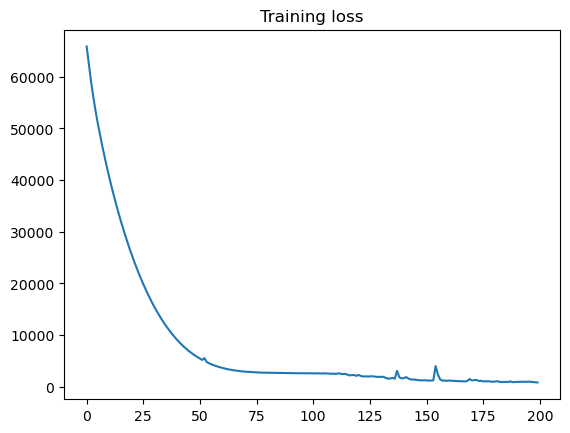

In [92]:
plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

In [123]:
# Оценка на тестовых данных
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        print("feqw", outputs.shape)
        loss = criterion(outputs.squeeze(), y_batch[:, -1])  # Последний шаг
        test_loss += loss.item()
        

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
feqw torch.Size([16, 1])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
feqw torch.Size([16, 1])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
feqw torch.Size([16, 1])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
feqw torch.Size([16, 1])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
feqw torch.Size([16, 1])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1001, 64])
in forward, last_out  torch.Size([16, 64])
feqw torch.Size([16, 1])
in forward, x  torch.Size([16, 1001, 16])
in forward, out  torch.Size([16, 1

In [ ]:
#########################################################  NEW ERA   ##########################################################

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RadarDataset(Dataset):
    def __init__(self, X, y, window_size=1000):
        self.X = X
        self.y = y
        self.window_size = window_size
        
    def __len__(self):
        return self.X.shape[0]  # Количество траекторий

    def __getitem__(self, idx):
        # Формируем окна
        # Возьмем X и y для одной траектории
        trajectory_X = self.X[idx]  # (16, 1001, 16)
        trajectory_y = self.y[idx]  # (16, 1001)
        
        # Выбираем окна (16 радаров, window_size точек, 16 признаков)
        windows_X = []
        windows_y = []
        
        for radar in range(trajectory_X.shape[0]):  # Проходим по радарам
            for start in range(0, trajectory_X.shape[1] - self.window_size):
                end = start + self.window_size
                windows_X.append(trajectory_X[radar, start:end, :])  # Окно данных
                windows_y.append(trajectory_y[radar, end-1])  # Целевая координата в конце окна
                # тут -1 чтобы предсказывать текущую точку, т.к. нам надо уточнять оценку координат, а не предсказывать будущее
        
        windows_X = np.array(windows_X)  # (16*количество окон, 100, 16)
        windows_y = np.array(windows_y)  # (16*количество окон,)
        
        return torch.tensor(windows_X, dtype=torch.float32), torch.tensor(windows_y, dtype=torch.float32)
    
# Параметры для DataLoader
window_size = 1000 #если брать меньше, то больше обучающая выборка, но оперативы не хватает
batch_size = 1

train_size = int(0.8 * num_trajectories)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]
    
# from sklearn.preprocessing import StandardScaler

# Нормализуем данные
# train_scaler = StandardScaler()
# test_scaler = StandardScaler()
# # Пример нормализации для X (признаки)
# X_train_scaled = train_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test_scaled = test_scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
# 
# # Для y (цели) можно тоже использовать нормализацию или просто масштабировать в тот же диапазон
# y_train_scaled = train_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
# y_test_scaled = test_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
# 
# 
# train_dataset = RadarDataset(X_train_scaled, y_train_scaled, window_size=window_size)
# test_dataset = RadarDataset(X_test_scaled, y_test_scaled, window_size=window_size)

train_dataset = RadarDataset(X_train, y_train, window_size=window_size)
test_dataset = RadarDataset(X_test, y_test, window_size=window_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)   # Не перемешиваем данные
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) 

print("len of loaders", len(train_loader), len(test_loader))

# Пример батча
for X_batch, y_batch in train_loader:
    print(X_batch.shape)  # (16, seq_length, num_features) для каждого батча
    print(X_batch.view(-1, X_batch.shape[2], X_batch.shape[3]).shape)
    print(y_batch.shape)  # (16, seq_length)
    print(y_batch.view(-1).shape)
    print(X_batch.view(-1, X_batch.shape[2], X_batch.shape[3])[0][0])
    break

len of loaders 294 74
torch.Size([1, 16, 1000, 16])
torch.Size([16, 1000, 16])
torch.Size([1, 16])
torch.Size([16])
tensor([-2.8334e+04,  4.3923e+04, -1.2054e+03,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  5.2283e+04,  1.5939e+00,  2.1437e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  4.2509e-02,  3.7487e+00,  2.5409e-03,
         9.0565e-04])


In [67]:
import torch.nn as nn

# Функция инициализации весов с помощью метода Xavier
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)  # Инициализация весов
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # Инициализация смещений нулями
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Инициализация весов
        nn.init.constant_(m.bias, 0)  # Инициализация смещений нулями

class LSTMModel(nn.Module):
    def __init__(self, input_size=16, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Полносвязный слой для предсказания координаты x
        self.fc1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_len, hidden_size]
        last_hidden_state = lstm_out[:, -1, :]  # Берем последний временной шаг
        out = self.fc1(last_hidden_state)  # Прогнозируем координату x
        return out


Epoch [1/50], Loss: 9378845704.473909
Epoch [2/50], Loss: 9373282638.735880
Epoch [3/50], Loss: 9368222005.014532
Epoch [4/50], Loss: 9364058959.193163
Epoch [5/50], Loss: 9358892471.785471
Epoch [6/50], Loss: 9354174079.806135
Epoch [7/50], Loss: 9349214793.885025
Epoch [8/50], Loss: 9344284800.500996
Epoch [9/50], Loss: 9339287128.830809
Epoch [10/50], Loss: 9334834345.321854
Epoch [11/50], Loss: 9329557586.264402
Epoch [12/50], Loss: 9324617982.450521
Epoch [13/50], Loss: 9319755781.117081
Epoch [14/50], Loss: 9315025869.101643
Epoch [15/50], Loss: 9310258665.975447
Epoch [16/50], Loss: 9305356563.035395
Epoch [17/50], Loss: 9300046867.367027
Epoch [18/50], Loss: 9295187059.124840
Epoch [19/50], Loss: 9290314129.611448
Epoch [20/50], Loss: 9285550775.926552
Epoch [21/50], Loss: 9280612606.023544
Epoch [22/50], Loss: 9275766397.617958
Epoch [23/50], Loss: 9270919186.066114
Epoch [24/50], Loss: 9266060523.647905
Epoch [25/50], Loss: 9261229795.998272
Epoch [26/50], Loss: 9256411772.70

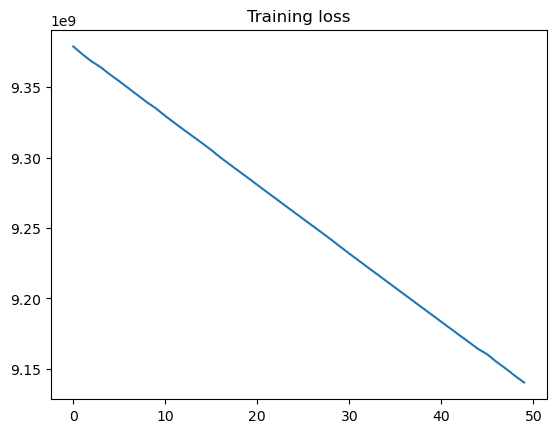

<All keys matched successfully>

In [69]:
import torch.optim as optim
from tqdm import tqdm
# Инициализируем модель
model = LSTMModel(input_size=16, hidden_size=128, num_layers=3, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение
num_epochs = 50
history = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
    # for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs = inputs.view(-1, inputs.shape[2], inputs.shape[3]).to(device)
        targets = targets.view(-1).to(device)
        # Прогноз
        optimizer.zero_grad()
        outputs = model(inputs)

        # Вычисление ошибки
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}')
    history.append(running_loss/len(train_loader))

plt.plot(np.arange(num_epochs), history)
plt.title("Training loss")
plt.show()

    
torch.save(model.state_dict(), './lstm_model.pth')
model.load_state_dict(torch.load('./lstm_model.pth', weights_only=True))

In [45]:
# Тестирование
model.eval()
test_loss = 0.0
test_loss_unscaled = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.view(-1, inputs.shape[2], inputs.shape[3]).to(device)
        targets = targets.view(-1).to(device)
        outputs = model(inputs)
        # print(outputs, targets)
        # unscaled_out = test_scaler.inverse_transform(outputs)
        # unscaled_targets = test_scaler.inverse_transform(targets.view(-1, 1))
        # diff = unscaled_out - unscaled_targets
        # print(unscaled_out, unscaled_targets)
        # print(diff)
        # print()
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
        # test_loss_unscaled += np.sum(diff)

print(f'Validation Loss: {test_loss/len(test_loader):.8f}')
# print(f'Validation Loss_true: {test_loss_unscaled/len(test_loader):.8f}')

Validation Loss: 1783253664.44444442


In [ ]:
# -----------------------------------------------------------------------------------------

In [49]:
import numpy as np
import os
import pandas as pd

# Константы
num_trajectories = 100  # Количество траекторий
num_radars = 16  # Количество радаров
data_path = 'data'  # Путь к данным
input_features = ['x_measure', 'v_x_measure_extr', 'r_measure', 'fi_measure', 'psi_measure']  # Входные признаки
target_feature = 'x_true'  # Целевая координата

def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси для одного радара
    return trajectory_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    trajectory_data = load_trajectory_data(traj_idx)
    
    # Для каждого радара, собираем последовательность (seq_length, num_features)
    radar_data = []
    radar_targets = []  # Список для целевых значений для каждого радара
    for radar_idx in range(num_radars):
        data = trajectory_data[radar_idx]
        X = data[input_features].values  # Входные данные для радарa
        y = data[target_feature].values  # Истинная координата
        
        radar_data.append(X)
        radar_targets.append(y)
    
    # Преобразуем данные в форму (num_radars, seq_length, num_features)
    X_data.append(np.array(radar_data))  # (num_radars, seq_length, num_features)
    y_data.append(np.array(radar_targets)) # (num_radars, seq_length)

# Преобразуем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, num_radars, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, seq_length)

# Теперь транспонируем X_data, y_data чтобы размерность стала (num_trajectories * num_radars, seq_length, num_features)
# print(X_data.shape[3])
X_data = X_data.reshape(-1, X_data.shape[2], X_data.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
y_data = y_data.reshape(-1, y_data.shape[2])

# Проверим размерность данных
print(X_data.shape)  # (100, 16, seq_length, num_features)
print(y_data.shape)  # (100, seq_length)


(1600, 101, 5)
(1600, 101)


In [43]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Полносвязный слой для регрессии
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Проход через LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Берем последний выход для предсказания
        out = out[:, -1, :]  # Последний временной шаг
        out = self.fc(out)  # Регрессия для получения предсказания координаты
        
        return out

# Инициализация модели
model = LSTMModel(input_size=len(input_features), hidden_size=64, num_layers=2)

# Использование на GPU, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
from torch.utils.data import DataLoader, TensorDataset

# Преобразуем данные в тензоры PyTorch
X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)

# Изменим размерность данных, чтобы у нас было (num_trajectories * num_radars, seq_length, num_features)
X_tensor = X_tensor.view(-1, X_tensor.shape[2], X_tensor.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
y_tensor = y_tensor.view(-1, y_tensor.shape[2])  # (num_trajectories * num_radars, seq_length)

# Создаем TensorDataset и DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Цикл обучения
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        print(X_batch.shape, y_batch.shape)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(X_batch)
        
        # Вычисление потерь
        loss = criterion(outputs, y_batch)  # Убираем лишнюю размерность
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}")


torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])


D:\Diplom\air_estimating_by_several_radars\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 101])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([16, 101, 5]) torch.Size([16, 101])
torch.Size([1

In [15]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Параметры
num_radars = 16
num_trajectories = 100
input_features = ['x_measure', 'v_x_measure_extr', 'r_measure', 'fi_measure', 'psi_measure']
target_feature = 'x_true'
data_path = 'data/'

# Функция для загрузки данных одной траектории
def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси
    traj_data = pd.concat(trajectory_data, axis=0).reset_index(drop=True)
    return traj_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    data = load_trajectory_data(traj_idx)
    X = data[input_features].values  # Входные данные
    y = data[target_feature].values  # Истинная координата
    X_data.append(X)
    y_data.append(y)

# Конвертируем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, seq_length)
print(X_data.shape)

# Заменяем NaN на 0 и Inf на большое число
X_data = np.nan_to_num(X_data, nan=0.0, posinf=1e6, neginf=-1e6)
y_data = np.nan_to_num(y_data, nan=0.0, posinf=1e6, neginf=-1e6)


# Делим на тренировочную и тестовую выборки
train_size = int(0.8 * num_trajectories)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Кастомный Dataset для PyTorch
class RadarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создаем DataLoader
batch_size = 1  # Один батч — одна траектория от всех радаров
train_dataset = RadarDataset(X_train, y_train)
test_dataset = RadarDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


(100, 1616, 5)


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Выходной слой для регрессии

    def forward(self, x):
        # LSTM: возвращает все временные шаги и последний скрытый слой
        out, (hidden, _) = self.lstm(x)
        # Выбираем последнее состояние и пропускаем через линейный слой
        return self.fc(hidden[-1])

# Параметры модели
input_size = len(input_features)  # Число входных признаков
hidden_size = 64
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)


device:  cpu
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])
torch.Size([1, 1616, 5]) torch.Size([1, 1616])


D:\Diplom\air_estimating_by_several_radars\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 57319.4002


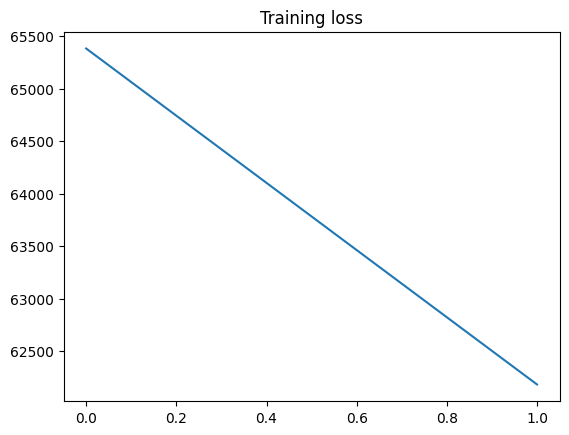

CPU times: total: 2min 27s
Wall time: 14.8 s


In [14]:
%%time
# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device: ", device)

# Обучение
num_epochs = 2
history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        print(X_batch.shape, y_batch.shape)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(X_batch)
        outputs = outputs.squeeze(-1)  # Убираем последнюю размерность для совместимости

        # Проверяем размерность целевого тензора
        if len(y_batch.shape) > 1:
            y_batch = y_batch[:, -1]  # Берем последний временной шаг для истинного значения

        # Вычисляем потери
        loss = criterion(outputs, y_batch)

        # Обратный проход
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Вычисляем среднее значение потерь за эпоху
    train_loss /= len(train_loader)
    history.append(train_loss)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


# Оценка на тестовых данных
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch[:, -1])  # Последний шаг
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

plt.plot(np.arange(num_epochs), history)
plt.title("Training loss")
plt.show()

In [5]:
%%time
# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device: ", device)

# Обучение
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(X_batch)
        outputs = outputs.squeeze(-1)  # Убираем последнюю размерность для совместимости

        # Проверяем размерность целевого тензора
        if len(y_batch.shape) > 1:
            y_batch = y_batch[:, -1]  # Берем последний временной шаг для истинного значения

        # Вычисляем потери
        loss = criterion(outputs, y_batch)

        # Обратный проход
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Вычисляем среднее значение потерь за эпоху
    train_loss /= len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


# Оценка на тестовых данных
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch[:, -1])  # Последний шаг
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


device:  cpu
Epoch [1/100], Loss: 65310.1636
Epoch [2/100], Loss: 62085.6763
Epoch [3/100], Loss: 58659.6536
Epoch [4/100], Loss: 55790.7667
Epoch [5/100], Loss: 53297.2489
Epoch [6/100], Loss: 50992.2295
Epoch [7/100], Loss: 48817.4113
Epoch [8/100], Loss: 46750.3469
Epoch [9/100], Loss: 44772.7603
Epoch [10/100], Loss: 42881.0486
Epoch [11/100], Loss: 41060.8761
Epoch [12/100], Loss: 39306.3765
Epoch [13/100], Loss: 37619.2231
Epoch [14/100], Loss: 35993.9506
Epoch [15/100], Loss: 34424.0276
Epoch [16/100], Loss: 32914.9060
Epoch [17/100], Loss: 31458.2173
Epoch [18/100], Loss: 30057.4309
Epoch [19/100], Loss: 28708.0938
Epoch [20/100], Loss: 27409.0876
Epoch [21/100], Loss: 26160.7731
Epoch [22/100], Loss: 24957.3623
Epoch [23/100], Loss: 23801.0492
Epoch [24/100], Loss: 22686.8096
Epoch [25/100], Loss: 21621.5690
Epoch [26/100], Loss: 20596.7670
Epoch [27/100], Loss: 19607.3759
Epoch [28/100], Loss: 18663.9536
Epoch [29/100], Loss: 17758.7482
Epoch [30/100], Loss: 16885.9193
Epoch 

C:\Users\lamin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 2123.0420
